In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# The Grid World

We have seen in class that we can obtain value function using [FittedValueIteration](https://deepnote.com/workspace/Underactuated-2ed1518a-973b-4145-bd62-1768b49956a8/project/526ff99b-f112-4247-9b0b-c52f0f88d6ce/notebook/on_a_mesh-44aac282aa1a436aafb2ac6ced3f1ccb). 

## Linear Programming for Dynamic Programming

For our discrete grid world, let's try to obtain the optimal cost-to-go using [linear programming](https://underactuated.csail.mit.edu/lyapunov.html#LP). Linear Programming is an optimization program with linear objective functions as well as linear equality and inequality constraints. If you are not familiar with optimization, you could take a look at the linear programming [tutorial](https://github.com/RobotLocomotion/drake/blob/master/tutorials/linear_program.ipynb) in Drake. The following cells are setting up the grid world and the transition matrix $T$ in eq(14) in the textbook.

In [2]:
xbins = range(0, 21)
ybins = range(0, 21)
[X, Y] = np.meshgrid(xbins, ybins)
states = np.vstack((X.reshape(441), Y.reshape(441)))

[ux, uy] = np.meshgrid([-1, 0, 1], [-1, 0, 1])
inputs = np.vstack((ux.reshape(9), uy.reshape(9)))

goal = [2, 8]


def obstacle(x):
    return x[0] >= 6 and x[0] <= 8 and x[1] >= 4 and x[1] <= 7


A = np.eye(2)
B = np.eye(2)

input_dim = inputs.shape[1]
state_dim = states.shape[1]
print(inputs)
#print(states)

T = np.zeros([state_dim, state_dim, input_dim])

for i in range(input_dim):
    for j in range(state_dim):
        next_state = A @ states[:, j] + B @ inputs[:, i]
        ind = np.argmin(np.linalg.norm(states.T - next_state, axis=1))
        T[j, ind, i] = 1

[[-1  0  1 -1  0  1 -1  0  1]
 [-1 -1 -1  0  0  0  1  1  1]]


In [3]:
def min_time_cost(x, u):
    state_cost = 1
    if obstacle(x):
        state_cost = 10
    if np.array_equal(x, goal):
        state_cost = 0
    action_cost = np.linalg.norm(u, 1)
    if action_cost > 1: # do not go diagonally!!!(punish if you go diagonally) see u / inputs
        action_cost = 10
    return state_cost + action_cost

Now it's your turn to code up the linear program for solving the optimal cost-to-go. These Drake [tutorials](https://github.com/RobotLocomotion/drake/tree/master/tutorials) could be super helpful for setting up the optimization program. To deal with numerical instability, you should use a discount factor $\gamma$ for the Bellman update: $$ J \leq l(a) + \gamma T(a) J, \quad \forall a.$$

In [4]:
import numpy as np
from pydrake.solvers import MathematicalProgram, Solve

# Create an empty MathematicalProgram named prog (with no decision variables,
# constraints or costs)
prog = MathematicalProgram()
J = prog.NewContinuousVariables(state_dim, "J")

gamma = 0.99999

for i in range(input_dim):
    #l = np.zeros(state_dim)
    for j in range(state_dim):
        ## Calculate cost using min_time_cost for current state and action
        ## states and inputs is a 2d array. states[j] selects the jth row of states
        ## states[:,j] selects the jth coloumn of states which is what we need
        ## use print(states) to see the 2d array first row contains x coordinates and second row contains y coordinates
        l = min_time_cost(states[:,j], inputs[:,i])  # modify here
        ## Modify here 
        ## Add Constraint for each entry of J
        # @ is matrix multiplication(dot product) in python. J and T[j, :, i] is a 1d vector of size 441(state_dim)
        # T has only 1's or 0's
        # T[j, :, i] contains next states reachable from current state states[:,j] and input inputs[:,i]
        # add constraint: J[j] <= l + gamma * T[j, :, i] @ J
        prog.AddLinearConstraint(J[j] <= l + gamma * T[j, :, i] @ J)


## Modify here
## Add cost to prog
# prog.AddLinearCost maximizes the input, -sum(J) maximizes negetive sum.
prog.AddLinearCost(-sum(J))

result = Solve(prog)
J_value = np.reshape(result.GetSolution(J), X.shape)

Let's visualize the value function you calculated using LP. It should be similiar to the plot obtained from FittedValueIteration.

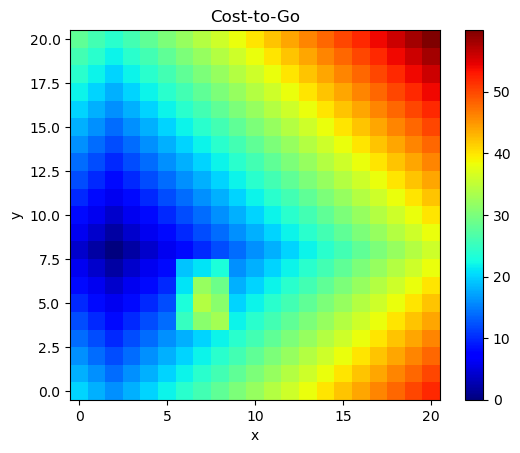

In [5]:
(fig, ax) = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Cost-to-Go")
k = ax.imshow(J_value, cmap=cm.jet)
ax.invert_yaxis()
plt.colorbar(k)
plt.show()

## Autograding
You can check your work by running the following cell:

In [6]:
from underactuated.exercises.dp.test_lp_dp import Testlpdp
from underactuated.exercises.grader import Grader

Grader.grade_output([Testlpdp], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 6/6.

Score for Test optimal cost-to-go from Linear Program is 6/6.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d2500c00-5719-4d8e-805a-0b78990978b1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>